In [1]:
# This script trains the model model_camera_rd_prob
# Augmentation: Individual images are randomly augmented, not at epoch end

import sys
import numpy as np
import os
from pathlib import Path
base_path = Path.cwd() 
# Libs path
sys.path.insert(0, str(base_path / 'model_arch' / 'libs'))
from tensorflow import keras
from datetime import datetime, timedelta
from utils import train_val_split, split_check, write_path, kittiroad_camera
from matplotlib import pyplot as plt
from tensorflow.keras.models import model_from_json
####################################################################################
from ds_layer_p2p_RT import DS1, DS1_activate, DS2, DS2_omega, DS3_Dempster, DS3_normalize, SelectSingleton # Ensure your custom layer module is imported


# cluster directory
input_dir_rgb = str(base_path / 'image_2')
input_dir_velo= str(base_path / 'all_channel')
target_dir = str(base_path / 'gt_road')
out_dir= str(base_path / 'output')
model_dir= str(base_path / 'model_arch' / 'model_camera_rd_prob')
weights = str(base_path / 'output' / '400epochs')

In [2]:
img_size = (384,1248)
batch_size = 1

# Load the JSON file
path_f = os.path.join(model_dir, "model_camera_rd_prob.json")
with open(path_f, "r") as json_file:
    model_json = json_file.read()

# Define the custom objects in a dictionary
custom_objects = {
    'DS1': DS1,
    'DS1_activate': DS1_activate,
    'DS2': DS2,
    'DS2_omega': DS2_omega,
    'DS3_Dempster': DS3_Dempster,
    'DS3_normalize':DS3_normalize, 
    'SelectSingleton':SelectSingleton}

# Reconstruct the model from JSON
model = model_from_json(model_json, custom_objects=custom_objects)
model.load_weights(os.path.join(weights,"checkpoint_cross_fusion"))

# # Load weights into the new model
# model.load_weights(os.path.join(model_dir, "model_camera_evi_ss_RT_weights.h5"))
#model.summary()

2024-07-05 09:57:29.210461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-05 09:57:29.213959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-05 09:57:29.214065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-05 09:57:29.214321: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
#Prepare paths of input images and target segmentation masks   
data_split = train_val_split(input_dir_rgb, target_dir)
train_input_img_paths_rgb = data_split["train_cam_1"]  # path of camera images, training
train_target_img_paths = data_split["train_target_1"]     # path of target image, training
val_input_img_paths_rgb = data_split["val_cam_1"]    # path of camera images, validation
val_target_img_paths = data_split["val_target_1"]       # path of taget image, validation 

# prepare split matching
train_cam= split_check(train_input_img_paths_rgb)
train_target= split_check(train_target_img_paths)
val_cam= split_check(val_input_img_paths_rgb)
val_target= split_check(val_target_img_paths)

# write split paths to a text file
write_path(out_dir, train_input_img_paths_rgb, 'train_input_img_paths_rgb.txt')
write_path(out_dir, train_target_img_paths, 'train_target_img_paths.txt')

write_path(out_dir, val_input_img_paths_rgb, 'val_input_img_paths_rgb.txt')
write_path(out_dir, val_target_img_paths, 'val_target_img_paths.txt')

0

(1, 384, 1248, 2)
(384, 1248, 2)


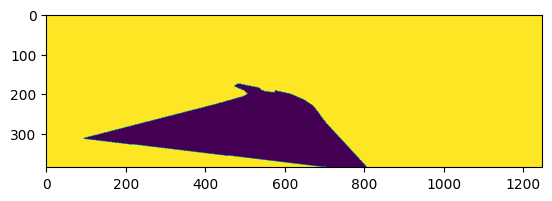

In [4]:
# Instantiate data Sequences for each split
train_gen = kittiroad_camera(batch_size, img_size, train_input_img_paths_rgb, train_target_img_paths)
val_gen = kittiroad_camera(batch_size, img_size, val_input_img_paths_rgb, val_target_img_paths,val=True)

# Index of an image for a check, can change up to max nr of images
index_of_image = 3 

# Access image from train or val_
image_batch = train_gen.__getitem__(index_of_image)

# Checking some batch images
first_image = image_batch[1]
print(first_image.shape)
tst = first_image[0]
print(tst.shape)
plt.figure()
plt.imshow(tst[:,:,0])

In [5]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

starter_learning_rate=0.0001
end_learning_rate=0
# Train the model
epochs = 10
decay_steps=261*epochs # 261(frames)x50(epoch) 
lr_schedule=keras.optimizers.schedules.PolynomialDecay(starter_learning_rate, decay_steps,end_learning_rate,power=0.9)

# Optimizer
opt=keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile
model.compile(optimizer=opt, loss= keras.losses.MeanSquaredError(), metrics= ["mse"])

# Modelcheckpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                            filepath=os.path.join(out_dir, 'model_camera_rd_prob_weights'),
                            save_weights_only=True,
                            monitor='val_loss', 
                            mode='min',
                            save_best_only=True)



st_time= datetime.now()
history= model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[model_checkpoint_callback])
end_time= datetime.now()


# Save training miscellaneous results
elapsed_total_sec= (end_time - st_time).total_seconds()
conversion = timedelta(seconds= elapsed_total_sec)

with open(os.path.join(out_dir, 'time_log.txt'), 'w') as f:
    f.write('%s\n' %'Training time in H:M:S')
    f.write( str(conversion))
    f.close()

np.savez_compressed(os.path.join(out_dir,'history.npz'), loss= history.history['loss'], 
                val_loss= history.history['val_loss'], 
               accuracy= history.history['mse'],
               val_accuracy= history.history['val_mse'] )

# Save model architecture to JSON after training
model_json = model.to_json()
with open(os.path.join(out_dir, 'model_camera_rd_prob.json'), "w") as json_file:
    json_file.write(model_json)

Epoch 1/10


2024-07-05 09:57:37.012464: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-07-05 09:57:37.424799: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-05 09:57:37.425482: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-05 09:57:37.425492: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-07-05 09:57:37.426043: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-05 09:57:37.426081: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


260/260 [==============================] - 15s 46ms/step - loss: 0.0271 - mse: 0.0077 - val_loss: 0.0267 - val_mse: 0.0073
Epoch 2/10
260/260 [==============================] - 12s 44ms/step - loss: 0.0273 - mse: 0.0079 - val_loss: 0.0267 - val_mse: 0.0073
Epoch 3/10
260/260 [==============================] - 12s 45ms/step - loss: 0.0275 - mse: 0.0081 - val_loss: 0.0267 - val_mse: 0.0073
Epoch 4/10
260/260 [==============================] - 12s 44ms/step - loss: 0.0273 - mse: 0.0079 - val_loss: 0.0267 - val_mse: 0.0073
Epoch 5/10
260/260 [==============================] - 12s 45ms/step - loss: 0.0273 - mse: 0.0079 - val_loss: 0.0267 - val_mse: 0.0073
Epoch 6/10
260/260 [==============================] - 11s 44ms/step - loss: 0.0271 - mse: 0.0077 - val_loss: 0.0267 - val_mse: 0.0073
Epoch 7/10
260/260 [==============================] - 11s 44ms/step - loss: 0.0273 - mse: 0.0079 - val_loss: 0.0267 - val_mse: 0.0073
Epoch 8/10
260/260 [==============================] - 12s 44ms/step - los

In [6]:
model.save_weights(os.path.join(out_dir, 'model_camera_rd_prob_weights.h5'))